# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets - Data Understanding

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

import sklearn as sk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

**Checking portfolio Dataset**

In [2]:
print('The shape of portfolio dataset is equal to {}'.format(portfolio.shape))
portfolio.head(10)

The shape of portfolio dataset is equal to (10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


**Checking profile Dataset**

In [3]:
print('The shape of profile dataset is equal to {}'.format(profile.shape))
profile.head()

The shape of profile dataset is equal to (17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
#Checking if there's any repeated id
print('There are {} unique ids in profile dataset.'.format(profile.id.nunique()))

There are 17000 unique ids in profile dataset.


**Checking transcript Dataset**

In [5]:
print('The shape of transcript dataset is equal to {}'.format(transcript.shape))
transcript.head()

The shape of transcript dataset is equal to (306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
#checking the unique elements of event in transcript dataset
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [7]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

# Data Preparation

In [8]:
#Splitting the "value" column of transcript dataset into columns

transcript = pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)

In [9]:
transcript.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [10]:
#combine info from 'offer id' and 'offer_id' into the first one

transcript['offer id'] = transcript['offer id'].combine_first(transcript['offer_id'])

In [11]:
transcript.drop(['offer_id'], axis=1, inplace=True)

In [12]:
transcript.head()

,event,person,time,offer id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [13]:
transcript.isnull().mean()

event       0.000000
person      0.000000
time        0.000000
offer id    0.453304
amount      0.546696
reward      0.890456
dtype: float64

In [14]:
#Checking the events related to null reward values

transcript[transcript['reward'].isnull()]['event'].unique()

array(['offer received', 'offer viewed', 'transaction'], dtype=object)

In [15]:
#Checking the events related to non null reward values

transcript[~transcript['reward'].isnull()]['event'].unique()

array(['offer completed'], dtype=object)

**According to the last code above, every reward line filled is connected to an event equals to 'offer completed'**

In [16]:
#Changing some column names from portfolio and transcript datasets

portfolio = portfolio.rename(columns={'id':'offer_id'})
transcript = transcript.rename(columns={'offer id':'offer_id'})

In [17]:
print(portfolio.columns)
print(transcript.columns)

Index(['channels', 'difficulty', 'duration', 'offer_id', 'offer_type',
       'reward'],
      dtype='object')
Index(['event', 'person', 'time', 'offer_id', 'amount', 'reward'], dtype='object')


In [18]:
#Merge of the transcript and portfolio dataframes

df = pd.merge(transcript, portfolio, on='offer_id', how='left')

In [19]:
df.head()

,event,person,time,offer_id,amount,reward_x,channels,difficulty,duration,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


In [20]:
#Check if offer id is the same for both dataframes (df and portfolio)

set(df[~df['offer_id'].isnull()]['offer_id']) == set(portfolio['offer_id'].unique())

True

In [21]:
#Check if all rows are filled correctly according to portfolio information dataframe (sample)

portfolio.iloc[1, :]

channels          [web, email, mobile, social]
difficulty                                  10
duration                                     5
offer_id      4d5c57ea9a6940dd891ad53e9dbe8da0
offer_type                                bogo
reward                                      10
Name: 1, dtype: object

In [22]:
print(df[df['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0']['difficulty'].unique())
print(df[df['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0']['duration'].unique())
print(df[df['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0']['offer_id'].unique())
print(df[df['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0']['offer_type'].unique())
print(df[df['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0']['reward_y'].unique())

[ 10.]
[ 5.]
['4d5c57ea9a6940dd891ad53e9dbe8da0']
['bogo']
[ 10.]


**Looks that everything is ok!**

In [23]:
#Merge profile to the merged dataframes

profile = profile.rename(columns={'id':'person_id'})
df = df.rename(columns={'person':'person_id'})

df = pd.merge(df, profile, on='person_id', how='left')

In [24]:
#Check if all rows are filled correctly according to profile information dataframe (sample)

profile.iloc[2, :]

age                                              118
became_member_on                            20180712
gender                                          None
person_id           38fe809add3b4fcf9315a9694bb96ff5
income                                           NaN
Name: 2, dtype: object

In [25]:
print(df[df['person_id'] == '38fe809add3b4fcf9315a9694bb96ff5']['age'].unique())
print(df[df['person_id'] == '38fe809add3b4fcf9315a9694bb96ff5']['became_member_on'].unique())
print(df[df['person_id'] == '38fe809add3b4fcf9315a9694bb96ff5']['gender'].unique())
print(df[df['person_id'] == '38fe809add3b4fcf9315a9694bb96ff5']['person_id'].unique())
print(df[df['person_id'] == '38fe809add3b4fcf9315a9694bb96ff5']['income'].unique())

[118]
[20180712]
[None]
['38fe809add3b4fcf9315a9694bb96ff5']
[ nan]


**Looks that everything is ok!**

In [26]:
#Rename the reward columns

df = df.rename(columns={'reward_x':'reward_completed', 'reward_y':'reward_offered'})

In [27]:
df.isnull().mean()

event               0.000000
person_id           0.000000
time                0.000000
offer_id            0.453304
amount              0.546696
reward_completed    0.890456
channels            0.453304
difficulty          0.453304
duration            0.453304
offer_type          0.453304
reward_offered      0.453304
age                 0.000000
became_member_on    0.000000
gender              0.110174
income              0.110174
dtype: float64

In [28]:
df[df['event'] == 'transaction']['offer_id'].unique()

array([nan], dtype=object)

In [29]:
df[df['offer_id'].isnull()]['event'].unique()

array(['transaction'], dtype=object)

**From above we can see that every transaction event is related to a null value in offer_id columns. That's because these are the transactions without any promotion been offered.**

**Another point, offer_id, amount and reward columns are derived from a split, so they are complementar and that's why we can see that missing vlaues.**

In [30]:
print(df[df['event'] == 'transaction']['channels'].unique())
print(df[df['event'] == 'transaction']['difficulty'].unique())
print(df[df['event'] == 'transaction']['duration'].unique())
print(df[df['event'] == 'transaction']['offer_type'].unique())
print(df[df['event'] == 'transaction']['reward_offered'].unique())

[nan]
[ nan]
[ nan]
[nan]
[ nan]


**Above we can see the other columns that have missing values because they are related to a no promo offered transaction.** 

In [31]:
#Checking the age values where gender is null

df[df['gender'].isnull()]['age'].describe()

count    33772.0
mean       118.0
std          0.0
min        118.0
25%        118.0
50%        118.0
75%        118.0
max        118.0
Name: age, dtype: float64

In [32]:
#Checking the age values where income is null

df[df['income'].isnull()]['age'].describe()

count    33772.0
mean       118.0
std          0.0
min        118.0
25%        118.0
50%        118.0
75%        118.0
max        118.0
Name: age, dtype: float64

**Above we can see that values with income and gender equal null are related to data with 118 years old. Let's take it as an error and drop them.**

In [33]:
df = df.dropna(subset=['income', 'gender'])

In [34]:
#Transforming date column to datetime

df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

In [35]:
#Extract and create a new column with year

df['year_became_member'] = df['became_member_on'].dt.year 

In [36]:
df.describe()

,time,amount,reward_completed,difficulty,duration,reward_offered,age,income,year_became_member
count,272762.000000,123957.000000,32444.000000,148805.000000,148805.000000,148805.000000,272762.000000,272762.000000,272762.000000
mean,366.707694,13.996325,4.948249,7.890561,6.625207,4.442445,53.840696,64337.000755,2016.457435
std,200.359087,31.749420,2.905376,5.041335,2.133035,3.372362,17.551337,21243.762941,1.218663
min,0.000000,0.050000,2.000000,0.000000,3.000000,0.000000,18.000000,30000.000000,2013.000000
25%,186.000000,3.660000,2.000000,5.000000,5.000000,2.000000,41.000000,48000.000000,2016.000000
50%,408.000000,10.800000,5.000000,10.000000,7.000000,5.000000,55.000000,62000.000000,2017.000000
75%,528.000000,19.130000,5.000000,10.000000,7.000000,5.000000,66.000000,78000.000000,2017.000000
max,714.000000,1062.280000,10.000000,20.000000,10.000000,10.000000,101.000000,120000.000000,2018.000000


In [37]:
#Checking the values above 0,75 quantile for age

df[df['age'] > 66]['age'].unique()

array([ 75,  68,  78,  88,  96,  69,  79,  73,  67,  76,  74,  70,  90,
        72,  71,  83,  77,  81,  89,  85, 100,  82,  80,  84,  87,  86,
        94,  95,  93,  92,  98,  91, 101,  97,  99])

In [38]:
#Tukey test on Age data to check min and max values to identify outliers

Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)

IQR = Q3 - Q1

Max = Q3 + 1.5*IQR
Min = Q1 - 1.5*IQR
print('Min value {} , Max value {}'.format(Min,Max))

Min value 3.5 , Max value 103.5


**Based on Tukey test we decided to keep all values for age column**

# Exploratory Data analysis

**General type of events**

Text(0,0.5,'Frequency')

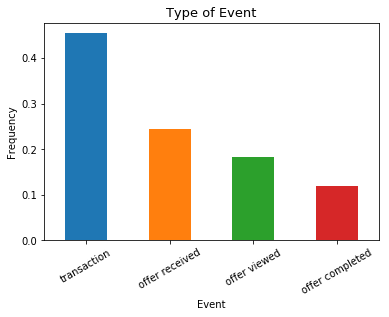

In [39]:
df.event.value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Type of Event', fontsize=13)
plt.xlabel('Event')
plt.ylabel('Frequency')

We see a big difference between transaction and the other three smaller groups in our dataset.

**General gender distribution**

Text(0,0.5,'Frequency')

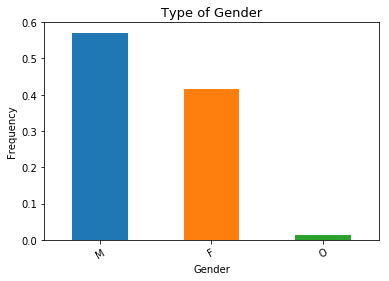

In [75]:
df.gender.value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Type of Gender', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Frequency')

Another information, we have more men in our data. 

**General type of offer**

Text(0,0.5,'Frequency')

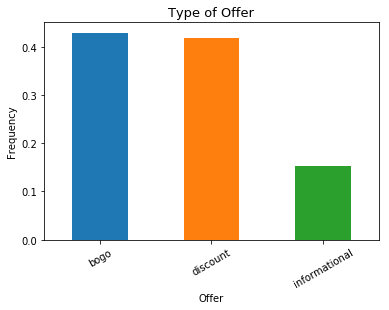

In [41]:
df.offer_type.value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Type of Offer', fontsize=13)
plt.xlabel('Offer')
plt.ylabel('Frequency')

Related to the offer, BOGO and discount are very similar in quantity, and informational is the smallest group. 

**General age distribution**

Text(0,0.5,'Frequency')

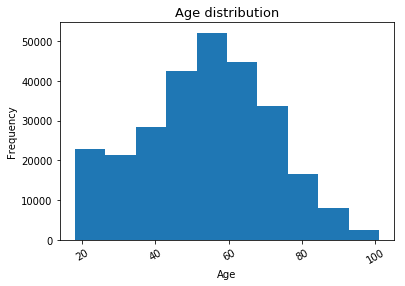

In [42]:
df.age.plot(kind='hist')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Age distribution', fontsize=13)
plt.xlabel('Age')
plt.ylabel('Frequency')

The distribution of the age in our dataset lays mainly from 40 to nearly 75 years old. 

**General income distribution**

Text(0,0.5,'Frequency')

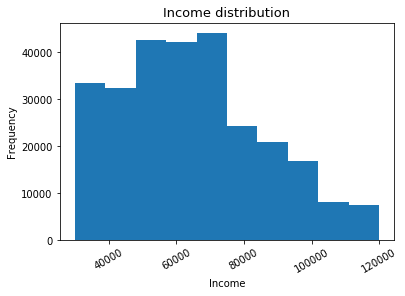

In [43]:
df.income.plot(kind='hist')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Income distribution', fontsize=13)
plt.xlabel('Income')
plt.ylabel('Frequency')

From the chart above we note that the income of our data lays mainly between 50K to nearly 70k.

**Necessary amount to complete an offer**

Text(0,0.5,'Frequency')

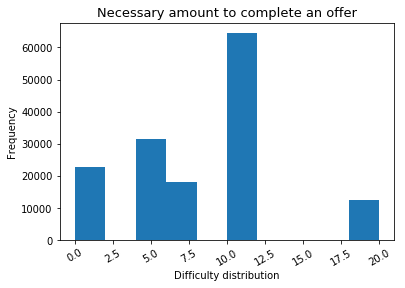

In [44]:
df.difficulty.plot(kind='hist')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Necessary amount to complete an offer', fontsize=13)
plt.xlabel('Difficulty distribution')
plt.ylabel('Frequency')

Related to the necessary amount to complete an offer, the range from 10 to nearly 12 is the most representative. 

## **Conversion analysis**

Let's get unique values with the combination of 'person_id', 'offer_id' and 'offer_type' **in order to evaluate the type of event associated with (offer completed,	offer received, offer viewed)**

**The main goal is to understand the relationship between a person, an offer and the convertion for each kind of promo**

In [45]:
#get dummie values from channels column

channels_dummie = pd.get_dummies(df['channels'].apply(pd.Series).stack()).sum(level=0)

df = pd.concat([df.drop(['channels'], axis=1), channels_dummie], axis=1)

In [46]:
#get dummie values from event column

event_dummies = pd.get_dummies(df['event'])

df = pd.concat([df.drop(['event'], axis=1), event_dummies], axis=1)

In [47]:
#Creating a second dataframe for conversion information

df_conv = df.groupby(['person_id', 'offer_id', 'offer_type'])['offer completed', 'offer received', 'offer viewed'].sum().reset_index()

In [48]:
#apply conditions to count values with view and completed

conditions = [
    (df_conv['offer completed'] == df_conv['offer viewed']),
    (df_conv['offer completed'] > df_conv['offer viewed']),
    (df_conv['offer completed'] < df_conv['offer viewed'])]
choices = [df_conv['offer completed'], df_conv['offer viewed'], df_conv['offer completed']]

In [49]:
df_conv['conversion_count'] = np.select(conditions, choices)

### **Conversion for bogo promo**

In [50]:
#Conversion for bogo promo

bogo_conv = df_conv[df_conv['offer_type'] == 'bogo']['conversion_count'].sum() / df_conv[df_conv['offer_type'] == 'bogo']['offer viewed'].sum()

print('The conversion rate for bogo offers is {:.4f}.'.format(bogo_conv))

The conversion rate for bogo offers is 0.5957.


### **Conversion for discount promo**

In [51]:
#Conversion for discount promo

discount_conv = df_conv[df_conv['offer_type'] == 'discount']['conversion_count'].sum()/df_conv[df_conv['offer_type'] == 'discount']['offer viewed'].sum()

print('The conversion rate for discount offers is {:.4f}.'.format(discount_conv))

The conversion rate for discount offers is 0.7471.


### Conversion for informational promo 

**In this case we analyze the view rate, since there is no complete count for informational**

In [52]:
#Conversion for informational promo - IN THIS CASE WE ANALYZE THE VIEW RATE, SINCE THERE IS NO COMPLETE COUNT FOR INFORMATIONAL

informational_view = df_conv[df_conv['offer_type'] == 'informational']['offer viewed'].sum()/df_conv[df_conv['offer_type'] == 'informational']['offer received'].sum()

print('The view rate for informational offers is {:.4f}.'.format(informational_view))

The view rate for informational offers is 0.7038.


If we compare the results above, the discount offer is the best in conversion performance. It means, considering users that saw the offer, if it is a discount one, it is more likely that a user make the action we expect (buy a product). 

### Analysis of BOGO users who completed (at least once) x not completed

**BOGO users who bought at least once after viewing the promo (positive users)**

In [53]:
users_bogo_positive = list(df_conv.query("offer_type == 'bogo' & conversion_count >0")['person_id'].unique())

In [54]:
print('Age and income for BOGO positive users:')
df[df['person_id'].isin(users_bogo_positive)].describe()[['age', 'income']]

Age and income for BOGO positive users:


,age,income
count,169292.000000,169292.000000
mean,55.103549,67772.009309
std,17.056188,21199.724181
min,18.000000,30000.000000
25%,44.000000,52000.000000
50%,56.000000,66000.000000
75%,67.000000,83000.000000
max,101.000000,120000.000000


**BOGO users who viewed the promo but did not buy (negative users)**

In [55]:
users_bogo_negative = list(df_conv[(df_conv['offer_type'] == 'bogo') & (df_conv['offer viewed'] > 0) & (df_conv['offer completed'] == 0)]['person_id'].unique())

In [56]:
print('Age and income for BOGO negative users:')
df[df['person_id'].isin(users_bogo_negative)].describe()[['age', 'income']]

Age and income for BOGO negative users:


,age,income
count,92680.000000,92680.000000
mean,50.942738,57088.098835
std,18.224909,19068.648355
min,18.000000,30000.000000
25%,36.000000,41000.000000
50%,52.000000,55000.000000
75%,64.000000,69000.000000
max,100.000000,120000.000000


In [96]:
dif_age_bogo = (df[df['person_id'].isin(users_bogo_positive)].describe()[['age', 'income']].iloc[1][0]) / (
    df[df['person_id'].isin(users_bogo_negative)].describe()[['age', 'income']].iloc[1][0])

dif_income_bogo = (df[df['person_id'].isin(users_bogo_positive)].describe()[['age', 'income']].iloc[1][1]) / (
    df[df['person_id'].isin(users_bogo_negative)].describe()[['age', 'income']].iloc[1][1])

print('Users who converted a BOGO promo have an age {:.4f} % higher, and an income {:.4f} % higher.'.format(
    ((dif_age_bogo - 1)* 100), ((dif_income_bogo - 1)*100)))


Users who converted a BOGO promo have an age 8.1676 % higher, and an income 18.7148 % higher.


**Channels for BOGO positive users x negative users**

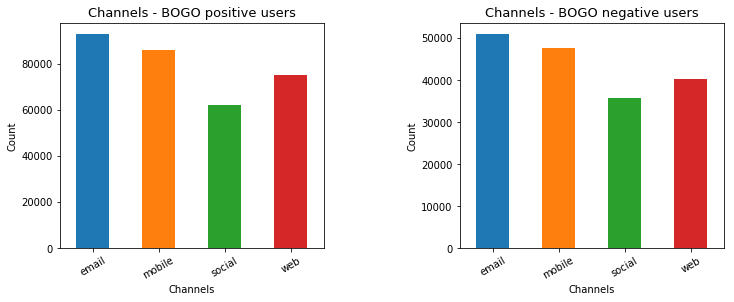

In [57]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
df[df['person_id'].isin(users_bogo_positive)][['email', 'mobile', 'social', 'web']].sum(axis=0).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Channels - BOGO positive users', fontsize=13)
plt.xlabel('Channels')
plt.ylabel('Count')

plt.subplot(1,2,2)
df[df['person_id'].isin(users_bogo_negative)][['email', 'mobile', 'social', 'web']].sum(axis=0).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Channels - BOGO negative users', fontsize=13)
plt.xlabel('Channels')
plt.ylabel('Count')


plt.tight_layout(pad=0.004, w_pad=8, h_pad=1.0)
plt.show()

**Gender of bogo positive users x negative users**

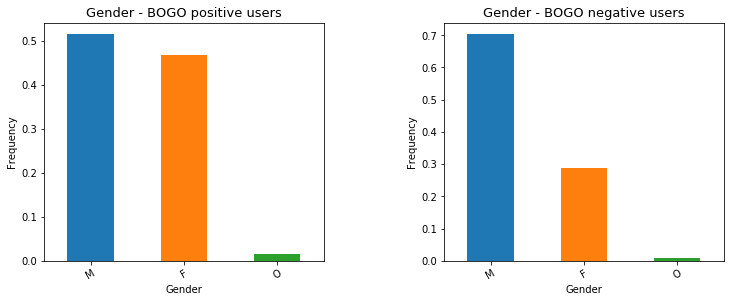

In [58]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
df[df['person_id'].isin(users_bogo_positive)]['gender'].value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Gender - BOGO positive users', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
df[df['person_id'].isin(users_bogo_negative)]['gender'].value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Gender - BOGO negative users', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Frequency')


plt.tight_layout(pad=0.004, w_pad=8, h_pad=1.0)
plt.show()

Above we can see that men tends to reject more the promos (after viewing)

### Analysis of discount users who completed (at least once) x not completed

**Discount users who bought at least once after viewing the promo**

In [59]:
users_discount_positive = list(df_conv.query("offer_type == 'discount' & conversion_count >0")['person_id'].unique())

In [60]:
print('Age and income for DISCOUNT positive users:')
df[df['person_id'].isin(users_discount_positive)].describe()[['age', 'income']]

Age and income for DISCOUNT positive users:


,age,income
count,184340.000000,184340.000000
mean,54.376874,65882.939134
std,17.283516,21087.902951
min,18.000000,30000.000000
25%,42.000000,51000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


**Discount users who viewed the promo but did not buy**

In [61]:
users_discount_negative = list(df_conv[(df_conv['offer_type'] == 'discount') & (df_conv['offer viewed'] > 0) & (df_conv['offer completed'] == 0)]['person_id'].unique())

In [62]:
print('Age and income for DISCOUNT negative users:')
df[df['person_id'].isin(users_discount_negative)].describe()[['age', 'income']]

Age and income for DISCOUNT negative users:


,age,income
count,43723.000000,43723.000000
mean,52.607552,59996.706539
std,17.612684,19941.499643
min,18.000000,30000.000000
25%,40.000000,44000.000000
50%,54.000000,57000.000000
75%,65.000000,72000.000000
max,101.000000,120000.000000


In [102]:
dif_age_disc = (df[df['person_id'].isin(users_discount_positive)].describe()[['age', 'income']].iloc[1][0]) / (
    df[df['person_id'].isin(users_discount_negative)].describe()[['age', 'income']].iloc[1][0])

dif_income_disc = (df[df['person_id'].isin(users_discount_positive)].describe()[['age', 'income']].iloc[1][1]) / (
    df[df['person_id'].isin(users_discount_negative)].describe()[['age', 'income']].iloc[1][1])

print('Users who converted a discount promo have an age {:.4f} % higher, and an income {:.4f} % higher.'.format(
    ((dif_age_disc - 1)* 100), ((dif_income_disc - 1)*100)))

Users who converted a discount promo have an age 3.3632 % higher, and an income 9.8109 % higher.


**Channels for discount positive users x negative users**

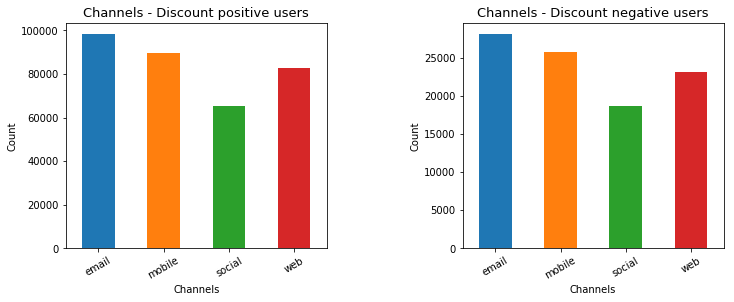

In [63]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
df[df['person_id'].isin(users_discount_positive)][['email', 'mobile', 'social', 'web']].sum(axis=0).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Channels - Discount positive users', fontsize=13)
plt.xlabel('Channels')
plt.ylabel('Count')

plt.subplot(1,2,2)
df[df['person_id'].isin(users_discount_negative)][['email', 'mobile', 'social', 'web']].sum(axis=0).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Channels - Discount negative users', fontsize=13)
plt.xlabel('Channels')
plt.ylabel('Count')


plt.tight_layout(pad=0.004, w_pad=8, h_pad=1.0)
plt.show()

**Gender of discount positive users x negative users**

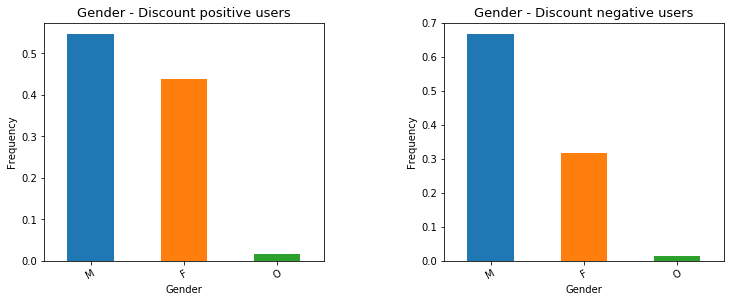

In [64]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
df[df['person_id'].isin(users_discount_positive)]['gender'].value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Gender - Discount positive users', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
df[df['person_id'].isin(users_discount_negative)]['gender'].value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Gender - Discount negative users', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Frequency')


plt.tight_layout(pad=0.004, w_pad=8, h_pad=1.0)
plt.show()

Above we see that as we checked for bogo users, in discount promos men tend to reject more the promos (after viewing).

### **Checking the profile of informational users who viewed (at least once) x did not view**

**informational users who viewed at least once after receiving the promo**

In [65]:
users_informational_positive = list(df_conv[(df_conv['offer_type'] == 'informational') & (df_conv['offer viewed'] == 1)]['person_id'].unique())

In [66]:
print('Age and income for INFORMATIONAL positive users:')
df[df['person_id'].isin(users_informational_positive)].describe()[['age', 'income']]

Age and income for INFORMATIONAL positive users:


,age,income
count,114934.000000,114934.000000
mean,54.216855,64473.523935
std,17.508678,20894.354427
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,62000.000000
75%,66.000000,78000.000000
max,101.000000,120000.000000


**Informational users who did not view the promo**

In [67]:
users_informational_negative = list(df_conv[(df_conv['offer_type'] == 'informational') & (df_conv['offer viewed'] == 0)]['person_id'].unique())

In [68]:
print('Age and income for INFORMATIONAL negative users:')
df[df['person_id'].isin(users_informational_negative)].describe()[['age', 'income']]

Age and income for INFORMATIONAL negative users:


,age,income
count,49429.000000,49429.000000
mean,53.521779,63623.783609
std,18.428161,22764.179218
min,18.000000,30000.000000
25%,39.000000,45000.000000
50%,55.000000,60000.000000
75%,67.000000,77000.000000
max,101.000000,120000.000000


In [104]:
dif_age_inf = (df[df['person_id'].isin(users_informational_positive)].describe()[['age', 'income']].iloc[1][0]) / (
    df[df['person_id'].isin(users_informational_negative)].describe()[['age', 'income']].iloc[1][0])

dif_income_inf = (df[df['person_id'].isin(users_informational_positive)].describe()[['age', 'income']].iloc[1][1]) / (
    df[df['person_id'].isin(users_informational_negative)].describe()[['age', 'income']].iloc[1][1])

print('Users who converted an informational promo have an age {:.4f} % higher, and an income {:.4f} % higher.'.format(
    ((dif_age_inf - 1)* 100), ((dif_income_inf - 1)*100)))

Users who converted an informational promo have an age 1.2987 % higher, and an income 1.3356 % higher.


**Channels for informational positive users x negative users**

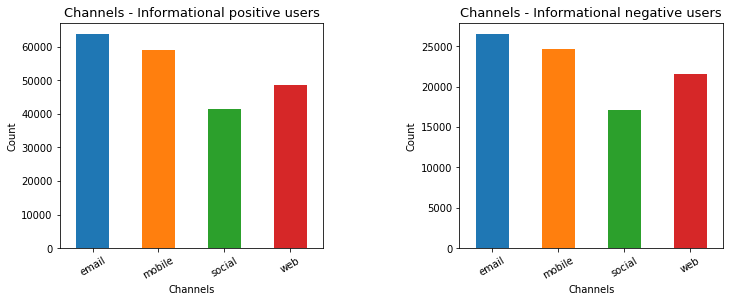

In [69]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
df[df['person_id'].isin(users_informational_positive)][['email', 'mobile', 'social', 'web']].sum(axis=0).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Channels - Informational positive users', fontsize=13)
plt.xlabel('Channels')
plt.ylabel('Count')

plt.subplot(1,2,2)
df[df['person_id'].isin(users_informational_negative)][['email', 'mobile', 'social', 'web']].sum(axis=0).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Channels - Informational negative users', fontsize=13)
plt.xlabel('Channels')
plt.ylabel('Count')


plt.tight_layout(pad=0.004, w_pad=8, h_pad=1.0)
plt.show()

**Gender of informational positive users x negative users**

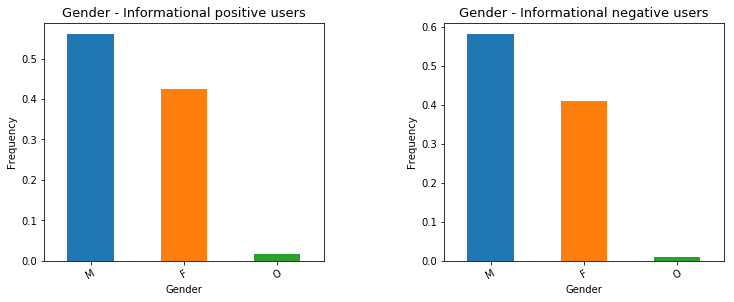

In [70]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
df[df['person_id'].isin(users_informational_positive)]['gender'].value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Gender - Informational positive users', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
df[df['person_id'].isin(users_informational_negative)]['gender'].value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Gender - Informational negative users', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Frequency')


plt.tight_layout(pad=0.004, w_pad=8, h_pad=1.0)
plt.show()

For informational promos, we do not see the great difference wich points that men tends to reject more the promos, although it still exists to a smaller extent.

**Some information we could highlight from the analysis above:**

* Offering a discount promo can give us a higher conversion rather than the other kind of promos
* In general, users who converts the promos tend to have a higher age and income
* Women tends to accept more the promos

**Checking the profile of users who completed a promo but did not view**

In [71]:
user_completed_not_view = list(df[(df['offer completed'] == 1)  & (df['offer viewed'] == 0)]['person_id'])

In [72]:
print('Age and income for users who completed a promo but did not view:')
df[df['person_id'].isin(user_completed_not_view)].describe()[['age', 'income']]

Age and income for users who completed a promo but did not view:


,age,income
count,239267.000000,239267.000000
mean,54.349576,65856.265177
std,17.346340,21378.005818
min,18.000000,30000.000000
25%,42.000000,50000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


**Channels for users who completed a promo not viewing**

Text(0,0.5,'Count')

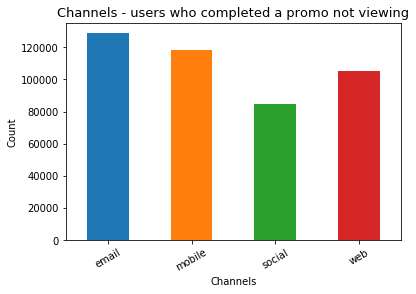

In [73]:
df[df['person_id'].isin(user_completed_not_view)][['email', 'mobile', 'social', 'web']].sum(axis=0).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Channels - users who completed a promo not viewing', fontsize=13)
plt.xlabel('Channels')
plt.ylabel('Count')

**Gender of users who completed a promo not viewing**

Text(0,0.5,'Frequency')

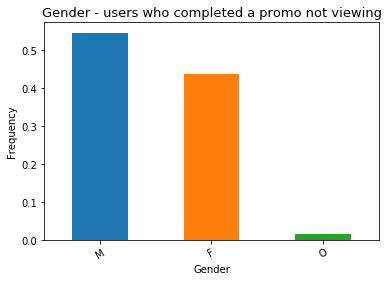

In [74]:
df[df['person_id'].isin(user_completed_not_view)]['gender'].value_counts(normalize=True).plot(kind='bar')

plt.xticks(rotation=30, horizontalalignment='center')
plt.title('Gender - users who completed a promo not viewing', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Frequency')

Based on the information above, we do not see a great difference in users who complete a promo even though they do not see it. 

# Data Modeling

Now let's create a model to predict if a costumer will convert or not a promotion

* we consider a promo as converted since the costumer view and complete at least once (receive and view for informational)

* we consider the combination of promo and costumer features to analyze if it is gonna be converted or not

* We map from df_conv the user and promo combination converted and label the rows according to that in the df dataframe


In [106]:
#Keep the values with transaction equals to zero (transaction values are related to no promo users)

df_model = df[df['transaction'] == 0]

In [107]:
df_model.head()

,person_id,time,offer_id,amount,reward_completed,difficulty,duration,offer_type,reward_offered,age,...,income,year_became_member,email,mobile,social,web,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,7.0,bogo,5.0,75,...,100000.0,2017,1.0,1.0,0.0,1.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0,7.0,discount,2.0,68,...,70000.0,2018,1.0,1.0,0.0,1.0,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,65,...,53000.0,2018,1.0,1.0,1.0,1.0,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,0.0,4.0,informational,0.0,58,...,51000.0,2017,1.0,1.0,0.0,1.0,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,20.0,10.0,discount,5.0,61,...,57000.0,2017,1.0,0.0,0.0,1.0,0,1,0,0


In [108]:
df_model.isnull().sum()

person_id                  0
time                       0
offer_id                   0
amount                148805
reward_completed      116361
difficulty                 0
duration                   0
offer_type                 0
reward_offered             0
age                        0
became_member_on           0
gender                     0
income                     0
year_became_member         0
email                      0
mobile                     0
social                     0
web                        0
offer completed            0
offer received             0
offer viewed               0
transaction                0
dtype: int64

In [109]:
#Dropping some columns we do not need

df_model = df_model.drop(['amount', 'reward_completed', 'offer completed', 'offer received', 'offer viewed', 'transaction', 'time', 'became_member_on'], axis=1)                   

In [110]:
df_model.head()

,person_id,offer_id,difficulty,duration,offer_type,reward_offered,age,gender,income,year_became_member,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,bogo,5.0,75,F,100000.0,2017,1.0,1.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,68,M,70000.0,2018,1.0,1.0,0.0,1.0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,5.0,65,M,53000.0,2018,1.0,1.0,1.0,1.0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,0.0,58,M,51000.0,2017,1.0,1.0,0.0,1.0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,61,F,57000.0,2017,1.0,0.0,0.0,1.0


In [111]:
#Concatenating person id and offer id to map with df_conv dataframe and check if that combination converted

df_model['concat_ids'] = df_model['person_id'].astype(str) + df_model['offer_id'].astype(str)

In [112]:
#Concatenating person id and offer id to map with df_model dataframe and check if that combination converted

df_conv['concat_ids'] = df_conv['person_id'].astype(str) + df_conv['offer_id'].astype(str)

In [113]:
#Creating a dict to map values as described above

dict_conv = pd.Series(df_conv.conversion_count.values,index=df_conv.concat_ids).to_dict()

In [114]:
#Map to get conversion information

df_model['conversion_count'] = df_model['concat_ids'].map(dict_conv)

In [115]:
#apply conditions for setting if an offer was completed or not (1 or 0)

conditions = [
    (df_model['conversion_count'] > 0),
    (df_model['conversion_count'] == 0)]

choices = [1, 0]

In [116]:
df_model['converted'] = np.select(conditions, choices)

In [117]:
#Dropping some unnecessary columns for our model

df_model.drop(['concat_ids', 'conversion_count'], axis=1, inplace=True)

In [118]:
#get dummie values from offer_type and gender columns

model_dummies = pd.get_dummies(df_model[['offer_type', 'gender']], drop_first=True)

In [119]:
df_model = pd.concat([df_model.drop(['offer_type', 'gender'], axis=1), model_dummies], axis=1)

In [120]:
df_model.head()

,person_id,offer_id,difficulty,duration,reward_offered,age,income,year_became_member,email,mobile,social,web,converted,offer_type_discount,offer_type_informational,gender_M,gender_O
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,5.0,75,100000.0,2017,1.0,1.0,0.0,1.0,1,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,2.0,68,70000.0,2018,1.0,1.0,0.0,1.0,0,1,0,1,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,65,53000.0,2018,1.0,1.0,1.0,1.0,1,0,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,4.0,0.0,58,51000.0,2017,1.0,1.0,0.0,1.0,0,0,1,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,5.0,61,57000.0,2017,1.0,0.0,0.0,1.0,0,1,0,0,0


In [121]:
#Split into feature and label / train and test

X = df_model.drop(['person_id', 'offer_id', 'converted'], axis=1)
y = df_model['converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Apply the model**

**In order to find the best params to our model we are going to use a Gridsearch function, and we are going to vary max leaf nodes, estimators and learning rate to get the best results.**

**In addition, we are going to use a pipeline to standardize our features before applying the model.**

**The metric chosen to evaluate our model and params is precision - our focus is to minimize the false positive. We want to avoid offering a promo to a person who will not convert - since it has a cost.**

In [122]:
#Creating a pipeline first for our model, including a standardizing process, and then check for best params using GridSearch 
#process
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=24))
])

params = {
    'clf__base_estimator__max_leaf_nodes': [6, 7],
    'clf__n_estimators': [200, 300],
    'clf__learning_rate': [0.9, 0.8]
}
    
    
cv = GridSearchCV(pipeline, param_grid=params, scoring='precision', verbose=3)

In [123]:
#Fit the model

cv.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=200 
[CV]  clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=200, score=0.7751440645409143, total=  20.9s
[CV] clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.5s remaining:    0.0s


[CV]  clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=200, score=0.7728989976869699, total=  23.4s
[CV] clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=200 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.3s remaining:    0.0s


[CV]  clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=200, score=0.7716336973955549, total=  25.4s
[CV] clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=300 
[CV]  clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=300, score=0.7787850612118394, total=  36.5s
[CV] clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=300 
[CV]  clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=300, score=0.7765265846296726, total=  30.8s
[CV] clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=300 
[CV]  clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.9, clf__n_estimators=300, score=0.7759815242494227, total=  29.2s
[CV] clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.8, clf__n_estimators=200 
[CV]  clf__base_estimator__max_leaf_nodes=6, clf__learning_rate=0.8, clf__n_estimators=200, score=0.77490184

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 10.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease...e=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=24))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__base_estimator__max_leaf_nodes': [6, 7], 'clf__n_estimators': [200, 300], 'clf__learning_rate': [0.9, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=3)

In [124]:
#Checking the best params
cv.best_params_

{'clf__base_estimator__max_leaf_nodes': 7,
 'clf__learning_rate': 0.9,
 'clf__n_estimators': 300}

In [125]:
#Predict in the test data

y_pred = cv.predict(X_test)

(array([ 0.5,  1.5]), <a list of 2 Text yticklabel objects>)

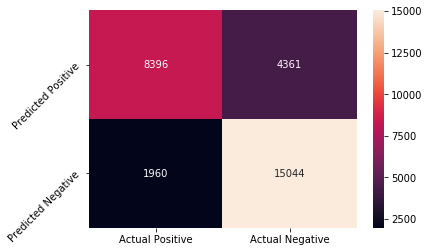

In [126]:
#Confusion matrix to evaluate our model

y_true = y_test
y_pred = y_pred
data = confusion_matrix(y_true, y_pred)


ax=sns.heatmap(data, annot=True, fmt='n')
ax.set_xticklabels(['Actual Positive', 'Actual Negative']) 
ax.set_yticklabels(['Predicted Positive','Predicted Negative'])
plt.yticks(rotation=45)

In [131]:
cl_report = classification_report(y_true, y_pred)
    
print("Classification Report:\n", cl_report)

Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.66      0.73     12757
          1       0.78      0.88      0.83     17004

avg / total       0.79      0.79      0.78     29761



# Evaluating our model and conclusion

The problem to be solved with this work is predict if a costumer will convert or not to a promo, since it was viewed/offered. To get it done, the first step was to prepare the data from the three datasets available: portfolio, profile and transcript. Then, I have concatenated them and created a new one which put in the same line each offer and customer to show if a promo was completed (or viewed in informational case) after being seen (or offered for informational). 

The model chosen was Adaboost Classifier, based on a Decision Tree classifier - combination which has proved to be a good choice for binary classification problems. 

In order to improve/tunning our model we choose to use a GridsearchCV, varying the params listed below. It is important to mention that we decided to reduce the quantity of params to improve for performance purposes. 

* clf__base_estimator__max_leaf_nodes: 7
* clf__learning_rate: 0.9
* clf__n_estimators: 300

According to the metric chosen to evaluate our model, precision, we found the best params and trained our model with them.

The result of our prediction got a precision rate about 78%. It means that when offering a promo to a user predicted as positive, we hit the right user (who will convert) 78% of the times **in our test set**.

For further analysis, we could try to fit other kind of models or feature engeneering (based on a study of the most important features to convert a user to a promo). It could be another approach in order to improve our results. 